In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from utils import LogitsToPredicate, MLP, MultiKANModel, DataLoader, DataLoaderMulti
from kan import KAN

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

X_columns = [
    'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 
    # 'Drate',
    # 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number',
    # 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count',
    # 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
    # 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 
    'IPv','LLC', 
    'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
    'Magnitue', 'Radius', 'Covariance',
    # 'Variance', 'Weight'
]

Y_columns = ['label_L2']

label_L1_mapping = {"MQTT": 0, "Benign": 1} 
label_L2_mapping = {"MQTT-DDoS-Connect_Flood": 0, "MQTT-DDoS-Publish_Flood": 1, 
                    "MQTT-DoS-Connect_Flood": 2, "MQTT-DoS-Publish_Flood": 3,
                    "MQTT-Malformed_Data": 4, "Benign": 5} 


# Read the CSV file
df = pd.read_csv('/home/zyang44/Github/baseline_cicIOT/CIC_IoMT/19classes/filtered_train_l_2_6.csv')
df['label_L1'] = df['label_L1'].map(label_L1_mapping)
df['label_L2'] = df['label_L2'].map(label_L2_mapping)

# Shuffle the dataframe before splitting into training and test sets
df = df.sample(frac=1, random_state=42)
# 90% as training set and 10% as test set
train_size = int(len(df) * 0.9)
train_df, test_df = df.iloc[:train_size, :], df.iloc[train_size:, :]

scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_df[X_columns])
test_X_scaled = scaler.transform(test_df[X_columns])
print("Any NaN in test_X_scaled:", np.isnan(test_X_scaled).any())
print("Any Inf in test_X_scaled:", np.isinf(test_X_scaled).any())

train_y = train_df[Y_columns].values.ravel()
test_y = test_df[Y_columns].values.ravel()
print("Unique train_y values:", np.unique(train_y))
print("Unique test_y values:", np.unique(test_y))
# take Y_columns as the label, and transfering to one-hot coded
dataset = {
    'train_input': torch.tensor(train_X_scaled, dtype=torch.float32, device=device),
    'train_label': F.one_hot(torch.tensor(train_y, dtype=torch.long, device=device), num_classes=6),
    'test_input': torch.tensor(test_X_scaled, dtype=torch.float32, device=device),
    'test_label': F.one_hot(torch.tensor(test_y, dtype=torch.long, device=device), num_classes=6)
}
print("Data prepared.",
      f"Train set: {dataset['train_input'].shape, dataset['train_label'].shape}",
      f"Test set: {dataset['test_input'].shape, dataset['test_label'].shape}", sep="\n")

# Define a dataset the label is numeric
dataset_numeric = {
    'train_input': torch.tensor(train_X_scaled, dtype=torch.float32, device=device),
    'train_label': torch.tensor(train_y, dtype=torch.long, device=device),
    'test_input': torch.tensor(test_X_scaled, dtype=torch.float32, device=device),
    'test_label': torch.tensor(test_y, dtype=torch.long, device=device)
}

cuda:0
Any NaN in test_X_scaled: False
Any Inf in test_X_scaled: False
Unique train_y values: [0 1 2 3 4 5]
Unique test_y values: [0 1 2 3 4 5]
Data prepared.
Train set: (torch.Size([35945, 18]), torch.Size([35945, 6]))
Test set: (torch.Size([3994, 18]), torch.Size([3994, 6]))


In [3]:
def compute_accuracy(loader, model):
    total_correct = 0
    total_samples = 0
    for data, labels in loader:
        logits = model(data)
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == labels).sum()
        total_samples += labels.numel()
    return total_correct.float() / total_samples

# Define the DataLoader adapted to the LTN input format. 'data' is same, 'labels' is numeric (not one-hot)
train_loader = DataLoader(
    data=dataset['train_input'], 
    labels=torch.tensor(train_y, dtype=torch.long, device=device), 
    batch_size=len(dataset['train_input']))
test_loader = DataLoader(
    data=dataset['test_input'], 
    labels=torch.tensor(test_y, dtype=torch.long, device=device), 
    batch_size=len(dataset['test_input']))

In [4]:
import ltn
import ltn.fuzzy_ops

# define the connectives, quantifiers, and the SatAgg
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())   # And = ltn.Connective(custom_fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
SatAgg = ltn.fuzzy_ops.SatAgg()

# define ltn constants
l_MQTT_DDoS_Connect_Flood = ltn.Constant(torch.tensor([1, 0, 0, 0, 0, 0]))
l_MQTT_DDoS_Publish_Flood = ltn.Constant(torch.tensor([0, 1, 0, 0, 0, 0]))
l_MQTT_DoS_Connect_Flood = ltn.Constant(torch.tensor([0, 0, 1, 0, 0, 0]))
l_MQTT_DoS_Publish_Flood = ltn.Constant(torch.tensor([0, 0, 0, 1, 0, 0]))
l_MQTT_Malformed_Data = ltn.Constant(torch.tensor([0, 0, 0, 0, 1, 0]))
l_Benign = ltn.Constant(torch.tensor([0, 0, 0, 0, 0, 1]))

# utils
import re

parse_mlp = lambda line: (
    float(re.search(r"Loss:\s*([\d\.]+)", line).group(1)),
    float(re.search(r"Test accuracy:\s*([\d\.]+)", line).group(1))
)

parse_kan = lambda line: (
    float(re.search(r"Epoch\s*\d+\s*\|\s*KAN\s*\(loss/acc/sat\):\s*([\d\.]+)", line).group(1)),
    float(re.search(r"KAN\s*\(loss/acc/sat\):\s*[\d\.]+/([\d\.]+)", line).group(1)),
    float(re.search(r"KAN\s*\(loss/acc/sat\):\s*[\d\.]+/[\d\.]+/([\d\.]+)", line).group(1))
)

**KL-h Plot**

Setting: [input(18), 6, 6, output(6)]

In [5]:
def compute_sat_levels(loader, P):
	sat_level  = 0
	for data, labels in loader:
		x = ltn.Variable("x", data)
		x_MQTT_DDoS_Connect_Flood = ltn.Variable("x_MQTT_DDoS_Connect_Flood", data[labels == 0])
		x_MQTT_DDoS_Publish_Flood = ltn.Variable("x_MQTT_DDoS_Publish_Flood", data[labels == 1])
		x_MQTT_DoS_Connect_Flood = ltn.Variable("x_MQTT_DoS_Connect_Flood", data[labels == 2])
		x_MQTT_DoS_Publish_Flood = ltn.Variable("x_MQTT_DoS_Publish_Flood", data[labels == 3])
		x_MQTT_Malformed_Data = ltn.Variable("x_MQTT_Malformed_Data", data[labels == 4])
		x_Benign = ltn.Variable("x_Benign", data[labels == 5])

		x_MQTT = ltn.Variable("x_MQTT", data[labels < 5])
		
		sat_level = SatAgg(
			Forall(x_MQTT_DDoS_Connect_Flood, P(x_MQTT_DDoS_Connect_Flood, l_MQTT_DDoS_Connect_Flood)),
			Forall(x_MQTT_DDoS_Publish_Flood, P(x_MQTT_DDoS_Publish_Flood, l_MQTT_DDoS_Publish_Flood)),
			Forall(x_MQTT_DoS_Connect_Flood, P(x_MQTT_DoS_Connect_Flood, l_MQTT_DoS_Connect_Flood)),
			Forall(x_MQTT_DoS_Publish_Flood, P(x_MQTT_DoS_Publish_Flood, l_MQTT_DoS_Publish_Flood)),
			Forall(x_MQTT_Malformed_Data, P(x_MQTT_Malformed_Data, l_MQTT_Malformed_Data)),
			Forall(x_Benign, P(x_Benign, l_Benign)),
			# hierarchical constraints
			Forall(x_MQTT, Not(P(x_MQTT, l_Benign)))
		)
	return sat_level
    
kan_h = KAN(width=[18, 6, 6, 6], grid=5, k=3, seed=42, device=device)
P_kan = ltn.Predicate(LogitsToPredicate(MultiKANModel(kan_h)))

# criterion = torch.nn.CrossEntropyLoss()
# kan_h.fit(dataset_numeric, steps=1, opt="Adam", loss_fn=criterion)

checkpoint directory created: ./model
saving model version 0.0


Problem of .fit():
* MultiKAN.fit() encapsulate only two optimizer, and can't switch loss_fn neatly
* use my code to train, need a way to SAVE THE MODEL, then LOAD MODEL to plot (MultiKAN.plot())

**decouple training from plotting**

In [8]:
optimizer_kan = torch.optim.Adam(P_kan.parameters(), lr=0.001)

# kan_loss, kan_acc, kan_sat = [], [], []
for epoch in range(401):
    # Train the KAN
	optimizer_kan.zero_grad()
	sat_kan = compute_sat_levels(train_loader, P_kan)
	loss = 1. - sat_kan
	loss.backward()
	optimizer_kan.step()
	train_loss_kan = loss.item()

	# Test the KAN
	acc_kan = compute_accuracy(test_loader, kan_h)
	test_sat_kan = compute_sat_levels(test_loader, P_kan)
	# kan_loss.append(train_loss_kan)
	# kan_acc.append(acc_kan.item())
	# kan_sat.append((sat_kan.item(), test_sat_kan.item())) # save the train/test sat in kan_sat
	if epoch % 10 == 0:
		print(f"Epoch {epoch}, Train Loss: {train_loss_kan:4f}, Test Accuracy: {acc_kan.item():4f}, Sat: {sat_kan.item():4f}/{test_sat_kan.item():4f}")
kan_h.saveckpt("kan_h")

Epoch 0, Train Loss: 0.745959, Test Accuracy: 0.296945, Sat: 0.254041/0.255737
Epoch 10, Train Loss: 0.738427, Test Accuracy: 0.443666, Sat: 0.261573/0.263531
Epoch 20, Train Loss: 0.730160, Test Accuracy: 0.426139, Sat: 0.269840/0.272085
Epoch 30, Train Loss: 0.720936, Test Accuracy: 0.420881, Sat: 0.279064/0.281618
Epoch 40, Train Loss: 0.710314, Test Accuracy: 0.429895, Sat: 0.289686/0.292542
Epoch 50, Train Loss: 0.698093, Test Accuracy: 0.484977, Sat: 0.301907/0.305006
Epoch 60, Train Loss: 0.684424, Test Accuracy: 0.495243, Sat: 0.315576/0.318934
Epoch 70, Train Loss: 0.669439, Test Accuracy: 0.499499, Sat: 0.330561/0.334160
Epoch 80, Train Loss: 0.653409, Test Accuracy: 0.504507, Sat: 0.346591/0.350270
Epoch 90, Train Loss: 0.636791, Test Accuracy: 0.510265, Sat: 0.363209/0.366761
Epoch 100, Train Loss: 0.620030, Test Accuracy: 0.519029, Sat: 0.379970/0.383214
Epoch 110, Train Loss: 0.603206, Test Accuracy: 0.534301, Sat: 0.396794/0.399618
Epoch 120, Train Loss: 0.586249, Test A

/home/zyang44/miniconda3/envs/LTN/lib/python3.11/site-packages/kan/MultKAN.py:571: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f'{path}_state')
/home/zy

Loaded KAN (acc/sat): 0.772659 / 0.228347


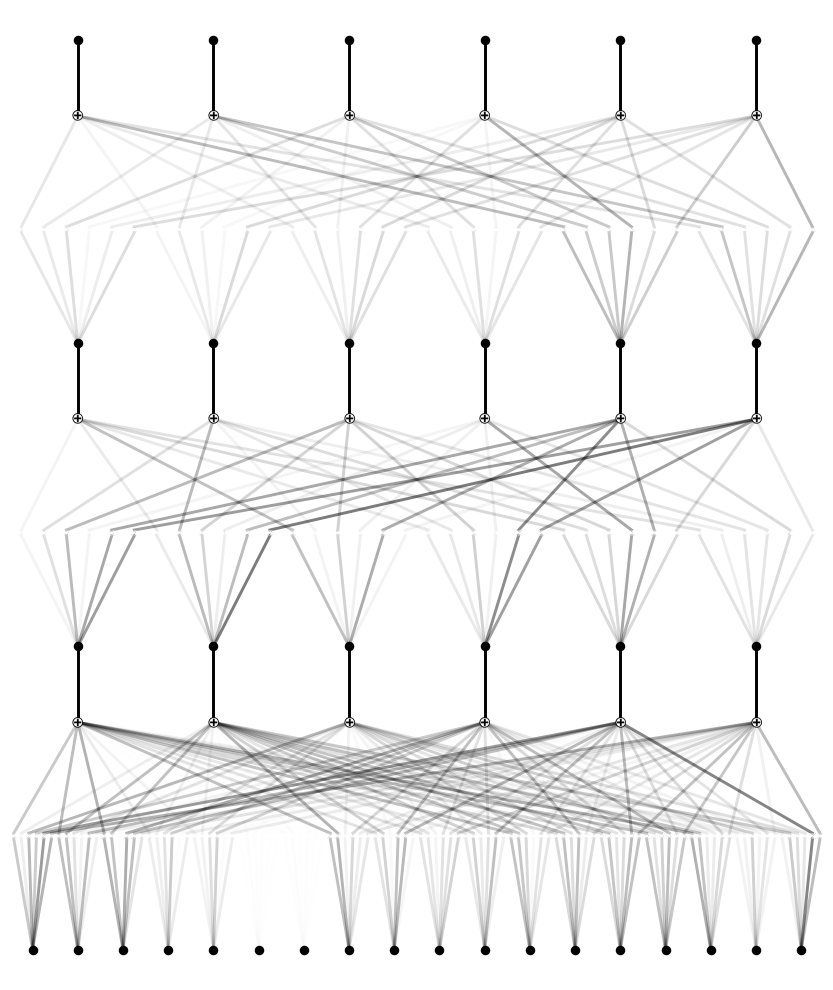

In [6]:
kan = KAN.loadckpt("kan_h")
kan.plot(scale=1.05)
print(f"Loaded KAN (acc/sat): {compute_accuracy(test_loader, kan):4f} / {compute_sat_levels(test_loader, P_kan):4f}")

**auto-swap**
The idea is to rearrange the order of neurons (i.e. swap them) so that neurons with strong connections (high “edge scores”, a measure of how “important” or strong that connection is) are placed closer together in the network’s internal representation.


saving model version 1.1


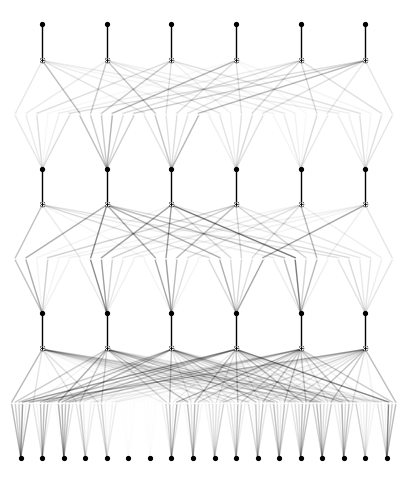

In [7]:
kan.auto_swap()
kan.plot()

Min edge score: 0.0007806308567523956 Max edge score: 0.18880414962768555


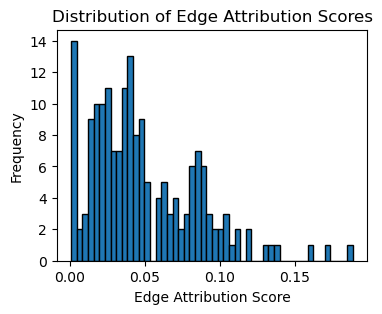

In [8]:
kan.attribute()  # Compute attribution scores first
min_edge = min([torch.min(es) for es in kan.edge_scores])
max_edge = max([torch.max(es) for es in kan.edge_scores])
print("Min edge score:", min_edge.item(), "Max edge score:", max_edge.item())

# Collect all edge scores into one flat tensor
all_edge_scores = []
for es in kan.edge_scores:
    # Flatten each layer's edge scores and add them to the list
    all_edge_scores.append(es.view(-1))
all_edge_scores = torch.cat(all_edge_scores)

edge_scores_np = all_edge_scores.cpu().detach().numpy()

import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
plt.hist(edge_scores_np, bins=50, edgecolor='black')
plt.xlabel("Edge Attribution Score")
plt.ylabel("Frequency")
plt.title("Distribution of Edge Attribution Scores")
plt.show()


saving model version 1.2
saving model version 1.2


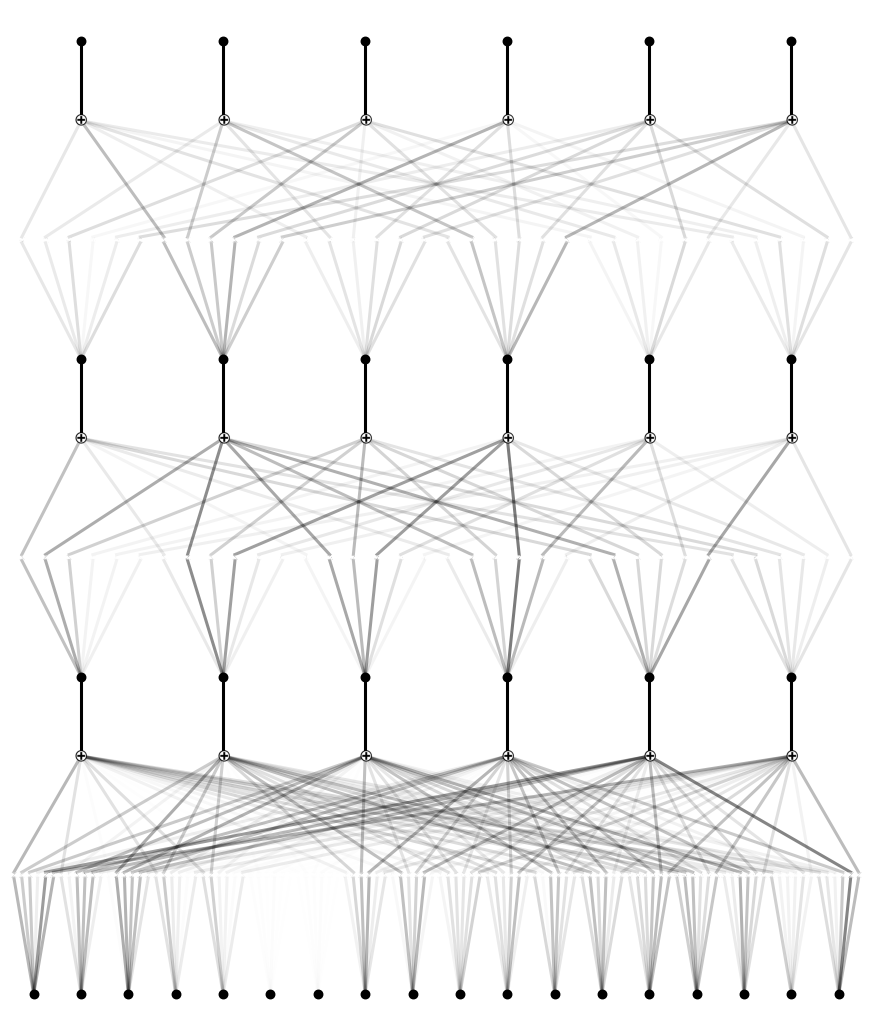

In [ ]:
kan.prune(edge_th=0.05)
kan.auto_swap()
# kan.plot(scale=1.05)

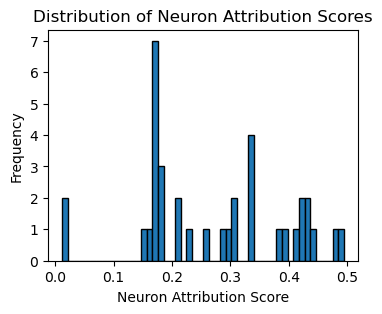

In [10]:
kan.attribute()

# Collect all neuron attribution scores from each layer
all_neuron_scores = []
for ns in kan.node_scores:
    all_neuron_scores.append(ns.view(-1).to(device))
all_neuron_scores = torch.cat(all_neuron_scores)

# Convert to numpy array for plotting
neuron_scores_np = all_neuron_scores.cpu().detach().numpy()

import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
plt.hist(neuron_scores_np, bins=50, edgecolor='black')
plt.xlabel("Neuron Attribution Score")
plt.ylabel("Frequency")
plt.title("Distribution of Neuron Attribution Scores")
plt.show()

saving model version 1.3


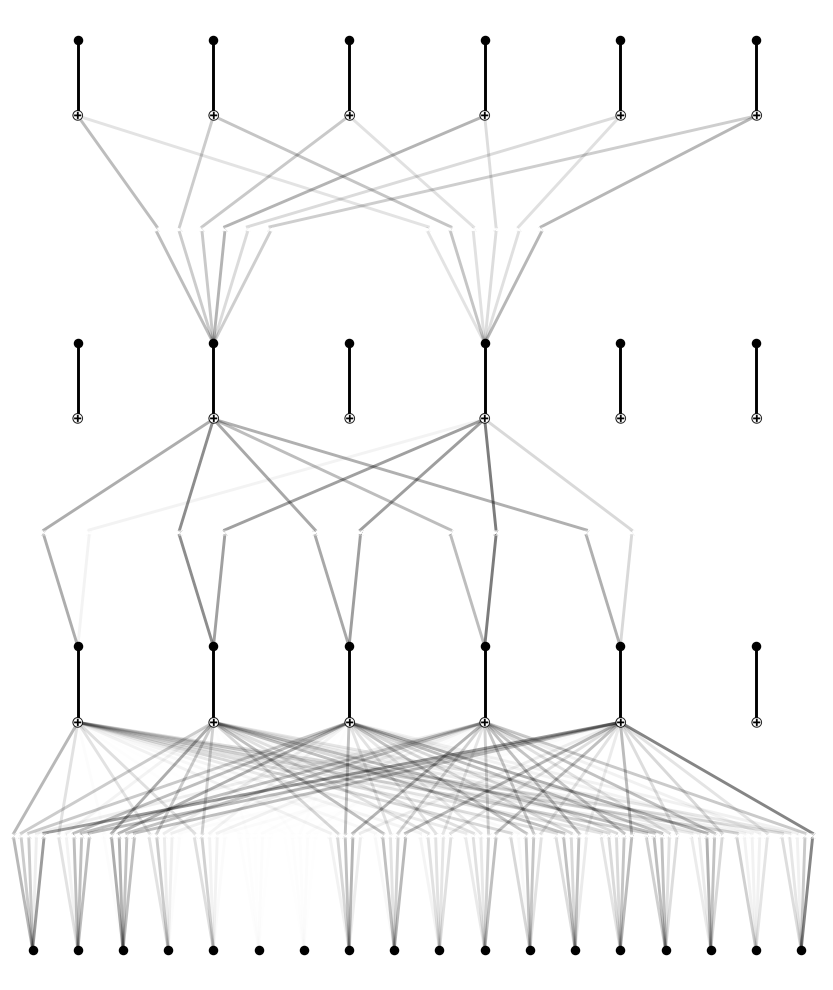

In [12]:
kan.prune(node_th=0.3)
kan.plot(scale=1.05)


saving model version 1.3


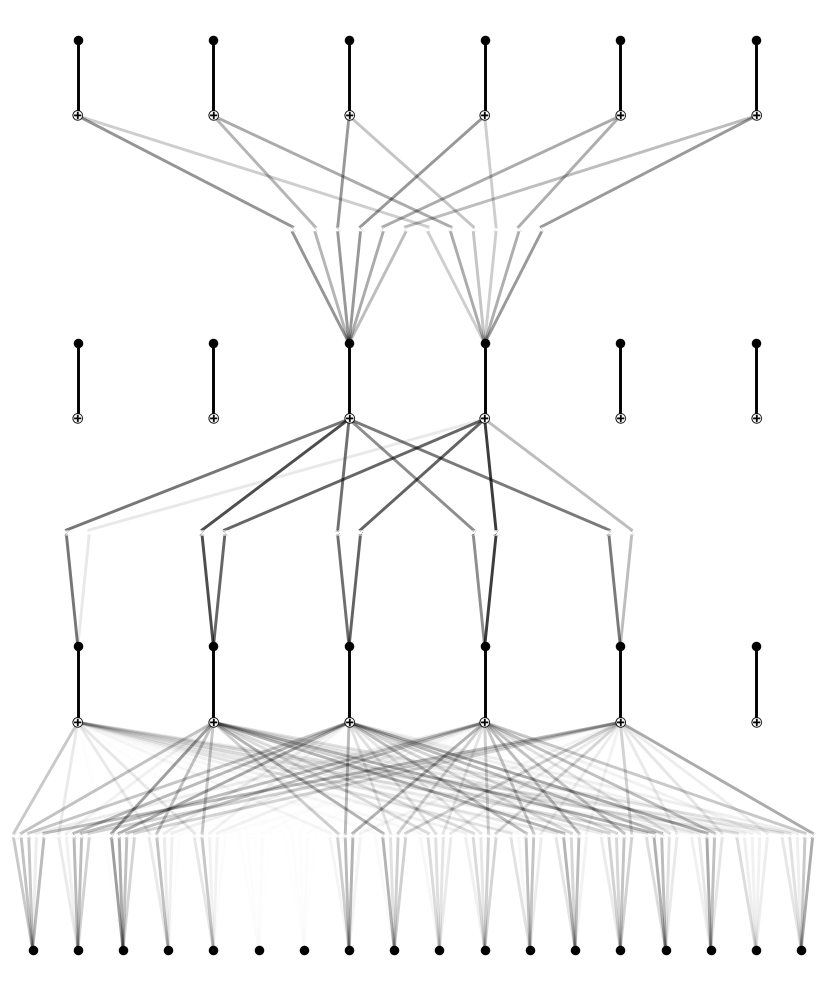

In [13]:
# kan.prune(edge_th=0.06)
kan.auto_swap()
kan.plot(scale=1.05)